# Kerasによる分析の実行

kerasのCNNモデルを用いて、移動平均と価格（終値）との距離から一定時間後の距離の期待値を求める

## 準備

### 必要なモジュールをimportする

In [ ]:
# データ操作用ライブラリ
import numpy as np
import pandas as pd

# 基本ライブラリ
import os
import sys
import getopt
import time
import math
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

# 機会学習用ライブラリ
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

# 進捗確認用プログレスバー
from tqdm.notebook import tqdm

# データアンダーサンプリング用ライブラリ
from imblearn.under_sampling import RandomUnderSampler

# グラフ用
from matplotlib import pyplot as plt

### 定数定義

In [ ]:
# 中間層の数
NUM_MIDDLE = 200

# ニューラルネットのモデルの定数
batch_size = 32   # 1回で投入するデータ量
time_steps = 288  # 5M足で1日分
epochs = 100 # モデル構築練習用の仮置き
validation_split = 0.25 # validationデータの割合
output_gap = 5    # 今回は各行にあるlabel列が教師データとなるため、時系列データとのgapは無い → やめ、close列のoutput_gap本後の価格で判定することにする
value_gap = 5     # pips。現在価格からvalue_gap価格変動があると予想した場合に売買する
learning_rate=0.0001  # 学習率

## データ読み込み

### 学習データを読み込み

In [ ]:
input_csv = 'drive/MyDrive/FX/AI/fx_cnn/data/shaped/DAT_ASCII_USDJPY_M1_2021_CONV.csv'

In [ ]:
# データファイル読み込み
df = pd.read_csv(
    input_csv,
    sep=',',
    converters={'open': Decimal, 'high': Decimal, 'low': Decimal, 'close': Decimal, 'Lema': Decimal, "Mema": Decimal, "Sema": Decimal,
                "L_Mdiff": Decimal, "L_Sdiff": Decimal, "L_Cdiff": Decimal, "M_Sdiff": Decimal, "M_Cdiff": Decimal, "S_Cdiff": Decimal, "weekday": Decimal},
    )
df

,open,high,low,close,Lema,Mema,Sema,L_Mdiff,L_Sdiff,L_Cdiff,M_Sdiff,M_Cdiff,S_Cdiff,weekday,feature,label
0,103.097000,103.197000,103.097000,103.195000,103.195,103.195,103.195,0.000,0.000,0.000000,0.000,0.000000,0.000000,6,0.032,0
1,103.195000,103.238000,103.195000,103.213000,103.1952,103.1955,103.1964,-0.0003,-0.0012,-0.017800,-0.0009,-0.017500,-0.016600,6,0.016,0
2,103.213000,103.229000,103.213000,103.213000,103.1954,103.1959,103.1977,-0.0005,-0.0023,-0.017600,-0.0018,-0.017100,-0.015300,6,0.016,0
3,103.213000,103.213000,103.212000,103.213000,103.1955,103.1964,103.1988,-0.0009,-0.0033,-0.017500,-0.0024,-0.016600,-0.014200,6,-0.014,0
4,103.213000,103.229000,103.212000,103.213000,103.1957,103.1968,103.1999,-0.0011,-0.0042,-0.017300,-0.0031,-0.016200,-0.013100,6,-0.020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74622,115.075000,115.075000,115.071000,115.073000,115.0855,115.0762,115.0684,0.0093,0.0171,0.012500,0.0078,0.003200,-0.004600,4,0.000,0
74623,115.073000,115.084000,115.072000,115.081000,115.0855,115.0763,115.0694,0.0092,0.0161,0.004500,0.0069,-0.004700,-0.011600,4,0.000,0
74624,115.081000,115.094000,115.078000,115.081000,115.0854,115.0764,115.0702,0.0090,0.0152,0.004400,0.0062,-0.004600,-0.010800,4,0.000,0
74625,115.085000,115.097000,115.069000,115.095000,115.0855,115.0769,115.0722,0.0086,0.0133,-0.009500,0.0047,-0.018100,-0.022800,4,0.000,0


## 整数化

### 通貨ペアに合わせ1pipsを1の位に合わせる

In [ ]:
integerize = 100

In [ ]:
integerized_arr = (df * integerize).astype('int').values

## アンダーサンプリング

### 2次元表から1次元追加し、TimeFrameごとのデータを作る

In [ ]:
bars = 72 # 5分足72本＝6時間分

In [ ]:
# 1pips(100分の1)単位に調整
y_class = (df[0:bars]['close'] * 100).astype('int').values
y_class

array([10319, 10321, 10321, 10321, 10321, 10322, 10322, 10322, 10319,
       10319, 10319, 10320, 10323, 10324, 10326, 10327, 10328, 10329,
       10326, 10329, 10328, 10327, 10323, 10324, 10321, 10316, 10312,
       10315, 10315, 10311, 10309, 10306, 10304, 10304, 10307, 10306,
       10306, 10308, 10308, 10308, 10310, 10311, 10311, 10309, 10307,
       10306, 10307, 10305, 10303, 10304, 10305, 10305, 10301, 10301,
       10302, 10301, 10299, 10298, 10299, 10298, 10299, 10298, 10299,
       10298, 10299, 10298, 10297, 10296, 10294, 10294, 10293, 10294])

In [ ]:
type(y_class)

numpy.ndarray

In [ ]:
min = y_class.min()
min

10293

In [ ]:
max = y_class.max()
max

10329

In [ ]:
cols = [x for x in range(min, max + 1, 1)]
print(f'最初の5行: { cols[:5] } , 最後の5行: { cols[-5:] } , listの長さ: { len(cols) }')

最初の5行: [10293, 10294, 10295, 10296, 10297] , 最後の5行: [10325, 10326, 10327, 10328, 10329] , listの長さ: 37


In [ ]:
encoder = OneHotEncoder(categories=[cols])

In [ ]:
# encoder_data = encoder.fit_transform(y_class.reshape(-1, 1))    # df["label"] -> labelのseries, values -> arrayに, reshape(-1, 1) -> 1列, 行は自動推定

In [ ]:
# y_one = encoder_data.toarray().astype('int64')

In [ ]:
encoder.set_params(sparse=False)
encoder_data = encoder.fit_transform(y_class.reshape(-1, 1))

In [ ]:
print(encoder_data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
type(encoder_data)

numpy.ndarray

In [ ]:
encoder_data.shape

(72, 37)

In [ ]:
y_one = np.flipud(encoder_data.T) # 転置して上下反転する。上限反転してるのは、上が小さい値(価格)になっているため

In [ ]:
y_one.shape

(37, 72)

In [ ]:
from PIL import Image

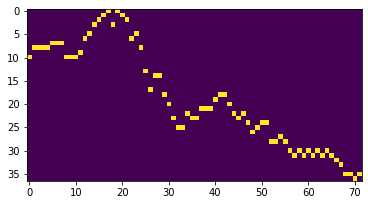

In [ ]:
# pil_img = Image.fromarray(y_one.astype(np.uint8) * 255).resize((362, 362))
pil_img = Image.fromarray(y_one * 255).resize((y_one.shape[1], y_one.shape[0]))
# pil_img.save('lena_save_pillow.jpg')
plt.imshow(np.array(pil_img))

OneHotにすると何列目がいくら、なのかわからなくなるが、重要なのはチャートの動きの形なのでそこがいくらなのかは関係ない。  
また、modelに入れるinputのshapeはどの入力データでも同じにしたいので、幅は広く取っておいたほうが良さそう(1円＝1000くらいで)  
EMAも含めた、最大値と最小値の中間を基準に上下500で行(OneHotの列)を定義すべし

In [ ]:
cnt = len(df['close']) - bars
cnt

74555

In [ ]:
diff_max =  0
for i in tqdm(range(cnt)):
  tm_steps = (df[i:i+bars]['close'] * 100).astype('int')
  min = tm_steps.min()
  max = tm_steps.max()
  if diff_max < (max - min):
    diff_max = (max - min)
    print(f'i = { i }')

diff_max

  0%|          | 0/74555 [00:00<?, ?it/s]

i = 0
i = 134
i = 136
i = 137
i = 138
i = 703
i = 712
i = 714
i = 717
i = 718
i = 719
i = 9084
i = 9085
i = 9086
i = 10213
i = 10215
i = 19123
i = 19124
i = 25738
i = 26638
i = 26641
i = 26642
i = 26647
i = 26649
i = 26650
i = 67191
i = 67192


116

上記より、1000ではダメで、1200カラムくらいのOneHotを作ったほうが良さそう  
→誤り。120で。

In [ ]:
price_steps = 120

下記を実行すると、メモリを食い尽くしてクラッシュする。なんとかしてデータ量を減らす必要がある  
このタイミングでアンダーサンプリングしてしまうのも手かもしれない。  
下げ、横ばい、上げを1:2:1の割合に分け、（インデックスがぐちゃぐちゃになるので）インデックスでソートした後、インデックス - bars～インデックスまでをひとかたまりにしてtime_seriesとする、みたいな

→steps数を120にしたら意外とメモリに収まったのでとりあえずOK。  
　本気で対策するなら"yield"と"fit_generator"で調べるべし  
　ここも https://aotamasaki.hatenablog.com/entry/2018/08/27/124349

In [ ]:
# y_class = (df['close'] * 100).astype('int').values
# y_class

array([10319, 10321, 10321, ..., 11508, 11509, 11510])

In [ ]:
# x = np.zeros((cnt, price_steps, bars))
# print(x.shape)
# y_class = (df['close'] * 100).astype('int').values
# for i in tqdm(range(cnt)):
#   # y_class = (df[i:i+bars]['close'] * 100).astype('int').values
#   y_frame = y_class[i:i+bars]
#   min = y_frame.min()
#   max = y_frame.max()
#   mid = (max - min) // 2 + min
#   range_min = mid - price_steps // 2
#   range_max = range_min + price_steps

#   # cols = [tmp for tmp in range(range_min, range_max, 1)]
#   cols = list(range(range_min, range_max, 1))
#   encoder = OneHotEncoder(categories=[cols], sparse=False)
#   encoder_data = encoder.fit_transform(y_frame.reshape(-1, 1))
#   x[i] = np.flipud(encoder_data.T)

(74555, 120, 72)


  0%|          | 0/74555 [00:00<?, ?it/s]

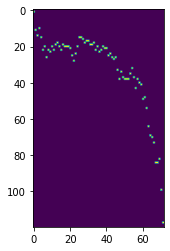

In [ ]:
# pil_img = Image.fromarray(x[67192] * 255).resize((x[67192].shape[1], x[67192].shape[0]))
# plt.imshow(np.array(pil_img))

In [ ]:
# del x

In [ ]:
def build_timeseries(input_data, label_data, time_steps=72, price_steps=120):
  dimention_0 = input_data.shape[0] - time_steps
  x = np.zeros((dimention_0, price_steps, time_steps))
  y = np.zeros((dimention_0,))
  print(x.shape)
  print(y.shape)

  x_class = (input_data * 100).astype('int').values

  for i in tqdm(range(dimention_0)):
    x_frame = x_class[i:i+time_steps]
    min = x_frame.min()
    max = x_frame.max()
    mid = (max - min) // 2 + min
    range_min = mid - price_steps // 2
    range_max = range_min + price_steps

    cols = list(range(range_min, range_max, 1))
    encoder = OneHotEncoder(categories=[cols], sparse=False)
    encoder_data = encoder.fit_transform(x_frame.reshape(-1, 1))
    x[i] = np.flipud(encoder_data.T)
    y[i] = label_data[i+time_steps]

  print("length of time-series i/o", x.shape, y.shape)
  return x, y

In [ ]:
# 深さ方向も考慮したちょい改造
def build_timeseries(input_data, label_data, time_steps=72, price_steps=120):
  dimention_0 = input_data.shape[0] - time_steps
  x = np.zeros((dimention_0, price_steps, time_steps, input_data.shape[1]))
  y = np.zeros((dimention_0,))
  print(x.shape)
  print(y.shape)

  x_class = (input_data * 100).astype('int').values

  for i in tqdm(range(dimention_0)):
    x_frame = x_class[i:i+time_steps]
    min = x_frame.min()
    max = x_frame.max()
    mid = (max - min) // 2 + min
    range_min = mid - price_steps // 2
    range_max = range_min + price_steps

    cols = list(range(range_min, range_max, 1))
    encoder = OneHotEncoder(categories=[cols], sparse=False)
    z = []
    for j in (range(input_data.shape[1])):
      encoder_data = encoder.fit_transform(x_frame[:, j].reshape(-1, 1))
      z.append(np.flipud(encoder_data.T))
    x[i] = np.dstack(z)
    del z
    y[i] = label_data[i+time_steps]

  print("length of time-series i/o", x.shape, y.shape)
  return x, y

In [ ]:
x_close = df[['close', 'Lema', 'Mema', 'Sema']]
y_class = df['label']

In [ ]:
X_all, y_all = build_timeseries(x_close, y_class)

In [ ]:
# x_close = df['close']
# x_L_ema = df['Lema']
# x_M_ema = df['Mema']
# x_S_ema = df['Sema']
# y_class = df['label']

In [ ]:
# X_all, y_all = build_timeseries(x_close, y_class)

In [ ]:
# # EMAも2次元画像化する
# X_L, _ = build_timeseries(x_L_ema, y_class)
# X_M, _ = build_timeseries(x_M_ema, y_class)
# X_S, _ = build_timeseries(x_S_ema, y_class)

(74555, 120, 72)
(74555,)


  0%|          | 0/74555 [00:00<?, ?it/s]

length of time-series i/o (74555, 120, 72) (74555,)


In [ ]:
# # そして、深さ方向にマージする
# X_all = np.dstack([X_all, X_L, X_M, X_S])

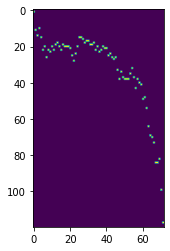

In [ ]:
pil_img = Image.fromarray(X_all[67192] * 255).resize((X_all[67192].shape[1], X_all[67192].shape[0]))
plt.imshow(np.array(pil_img))

In [ ]:
y_all

array([0., 0., 1., ..., 0., 0., 0.])

In [ ]:
# # 入力データからインプットとアウトプットのセットを作成(間引き前)
# X_all, y_all = build_timeseries(X_array, y_class, time_steps, output_gap)

  0%|          | 0/74334 [00:00<?, ?it/s]

length of time-series i/o (74334, 288, 10) (74334,)
